[PDF de la presentación de conclusiones](https://drive.google.com/file/d/17TmYrB4I9wgi5KoNGe1OAMuuaGeAjhrv/view?usp=sharing)


[Dashboard](https://public.tableau.com/views/CallMeMaybe_16957484570890/CallMeMaybe?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)

- - -

# Telecomunicaciones: identificar operadores ineficaces

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brinda información sobre los operadores menos eficaces.

 Sus clientes son organizaciones que necesitan distribuir gran cantidad de llamadas entrantes entre varios operadores, o realizar llamadas salientes a través de sus operadores. Los operadores también pueden realizar llamadas internas para comunicarse entre ellos. Estas llamadas se realizan a través de la red de CallMeMaybe.

#Tabla de contenidos

 1. [Objetivo](#1)
 2. [Preprocesamiento de datos](#2)
 3. [Análisis Exploratorio de Datos](#3)
 4. [Pruebas](#4)
 5. [Conclusiones](#5)
 6. [Documentación](#6)

# 1.-Objetivo

Con los datos proporcionados, se buscará identificar los operadores ineficaces del servicio de telefonía virtual CallMeMaybe tanto en su atención a llamadas internas y externas, salientes y entrantes.

Se considera que un operador es ineficaz si tiene:

* una gran cantidad de llamadas entrantes perdidas (internas y externas), esto definido por el 25% más alto de `missing_calls`. Para ello se filtrará con el quantil (.75), descartando los atípicos previamente.  


* un tiempo de espera prolongado para las llamadas entrantes, definido de igual forma por el 25% más alto de un `waiting_time` que es información que hay que generar a partir de los datos y descartando los atípicos.


* un número reducido de llamadas salientes si es que son parte de su tarea. Se asume que sí es parte de su tarea ya que el 80.76% de los operadores cuentan con al menos una llamada saliente  y, por otro lado, no contamos con información sobre diferentes tipos de operadores, así que se entiende que es un solo tipo con las mismas funciones. Este número reducido será definido por el quantil (.25) de llamadas `out`, sin los atípicos.



# 2.-Preprocesamiento de datos <a id='2'></a>

## 2.1.-Cargar librerías y datos

In [ ]:
#Cargar librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math as mth
from scipy import stats as st

In [ ]:
#Cargar datos
try:
    clients = pd.read_csv('/content/telecom_clients_us.csv')
    data    = pd.read_csv('/content/telecom_dataset_us.csv')
except:
    clients = pd.read_csv('/datasets/telecom_clients_us.csv')
    data    = pd.read_csv('/datasets/telecom_dataset_us.csv')

## 2.2.-Exploración general

Conocer en qué consisten los dataframes, tipos de datos, tamaño. Revisar los valores únicos de todas las columnas para conocer los rangos de trabajo, por ejemplo, observar rangos de fechas y etiquetas de las características.

### Data

El dataset `data` contiene las siguientes columnas:

- `user_id`: ID de la cuenta de cliente
- `date`: fecha en la que se recuperaron las estadísticas
- `direction`: "dirección" de llamada (`out` para saliente, `in` para entrante)
- `internal`: si la llamada fue interna (entre los operadores de un cliente o clienta)
- `operator_id`: identificador del operador
- `is_missed_call`: si fue una llamada perdida
- `calls_count`: número de llamadas
- `call_duration`: duración de la llamada (sin incluir el tiempo de espera)
- `total_call_duration`: duración de la llamada (incluido el tiempo de espera)

In [ ]:
#Visualizar las primeras filas del dataframe
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [ ]:
# Obtener los valores únicos de todas las columnas
unique_values = {}
for columna in data.columns:
    unique_values[columna] = data[columna].unique()

unique_values

{'user_id': array([166377, 166391, 166392, 166399, 166405, 166406, 166407, 166428,
        166481, 166482, 166485, 166487, 166495, 166503, 166507, 166511,
        166520, 166533, 166536, 166541, 166548, 166554, 166582, 166584,
        166585, 166604, 166609, 166619, 166636, 166649, 166658, 166660,
        166666, 166669, 166671, 166677, 166678, 166680, 166688, 166691,
        166692, 166697, 166708, 166711, 166713, 166717, 166725, 166726,
        166727, 166732, 166774, 166782, 166800, 166803, 166812, 166813,
        166833, 166836, 166837, 166839, 166843, 166874, 166879, 166884,
        166896, 166899, 166901, 166908, 166916, 166936, 166939, 166940,
        166941, 166946, 166955, 166958, 166971, 166973, 166974, 166975,
        166983, 166985, 166993, 166997, 167002, 167003, 167004, 167009,
        167011, 167012, 167016, 167031, 167035, 167052, 167053, 167059,
        167060, 167061, 167071, 167077, 167078, 167079, 167082, 167102,
        167109, 167110, 167112, 167113, 167114, 16712

In [ ]:
#Veamos
data.shape

(53902, 9)

#### Duplicados y nulos

In [ ]:
#Busquemos duplicados explícitos
data.duplicated().sum()

4900

In [ ]:
#Eliminémoslos
# [No funcionó por persistencia, tuve que poner el inplace]
data.drop_duplicates(inplace=True)
data

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
...,...,...,...,...,...,...,...,...,...
53896,168606,2019-11-10 00:00:00+03:00,out,True,957922.0,False,1,0,25
53897,168606,2019-11-10 00:00:00+03:00,out,True,957922.0,True,1,0,38
53898,168606,2019-11-11 00:00:00+03:00,out,True,957922.0,False,2,479,501
53899,168606,2019-11-15 00:00:00+03:00,out,True,957922.0,False,4,3130,3190


In [ ]:
#Y reajustar el índice
data = data.reset_index(drop=True)
data

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
...,...,...,...,...,...,...,...,...,...
48997,168606,2019-11-10 00:00:00+03:00,out,True,957922.0,False,1,0,25
48998,168606,2019-11-10 00:00:00+03:00,out,True,957922.0,True,1,0,38
48999,168606,2019-11-11 00:00:00+03:00,out,True,957922.0,False,2,479,501
49000,168606,2019-11-15 00:00:00+03:00,out,True,957922.0,False,4,3130,3190


In [ ]:
#Veamos tamaño, tipos y si hay nulos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49002 entries, 0 to 49001
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              49002 non-null  int64  
 1   date                 49002 non-null  object 
 2   direction            49002 non-null  object 
 3   internal             48892 non-null  object 
 4   operator_id          41546 non-null  float64
 5   is_missed_call       49002 non-null  bool   
 6   calls_count          49002 non-null  int64  
 7   call_duration        49002 non-null  int64  
 8   total_call_duration  49002 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.0+ MB


Tenemos nulos en `internal` y en `operator_id`.

In [ ]:
#En internal los datos son: True, False o Nan
#Veamos a qué están vinculados los nulos de internal
data[data['internal'].isna()]


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
917,166405,2019-09-18 00:00:00+03:00,in,NaN,NaN,True,1,0,59
996,166405,2019-10-01 00:00:00+03:00,in,NaN,NaN,True,1,0,1
1705,166406,2019-08-20 00:00:00+03:00,in,NaN,NaN,True,1,0,36
1761,166406,2019-09-02 00:00:00+03:00,in,NaN,879898.0,False,1,2,9
5645,166541,2019-09-26 00:00:00+03:00,in,NaN,908960.0,False,1,393,423
...,...,...,...,...,...,...,...,...,...
47702,168361,2019-11-09 00:00:00+03:00,in,NaN,NaN,True,6,0,14
47819,168361,2019-11-13 00:00:00+03:00,in,NaN,NaN,True,2,0,6
47844,168361,2019-11-14 00:00:00+03:00,in,NaN,NaN,True,1,0,2
48837,168579,2019-11-09 00:00:00+03:00,in,NaN,NaN,True,1,0,18


Hay nulos en `internal` cuando es una llamada entrante es una llamada perdida. Esto tiene sentido. Pero también los hay cuando la llamada sí se recibió. Veámoslos:

In [ ]:
#Localizar llamadas recibidas, con información nula en internal
a= data[(data['internal'].isna()) & (data['is_missed_call']==False)]
print(len(a))
a

54


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1761,166406,2019-09-02 00:00:00+03:00,in,NaN,879898.0,False,1,2,9
5645,166541,2019-09-26 00:00:00+03:00,in,NaN,908960.0,False,1,393,423
5651,166541,2019-09-26 00:00:00+03:00,in,NaN,908958.0,False,2,547,612
6846,166604,2019-11-01 00:00:00+03:00,in,NaN,893402.0,False,1,94,117
7862,166658,2019-09-24 00:00:00+03:00,in,NaN,890404.0,False,1,150,157
8245,166658,2019-10-15 00:00:00+03:00,in,NaN,890404.0,False,1,51,57
14706,166916,2019-10-01 00:00:00+03:00,in,NaN,906396.0,False,1,100,117
14816,166916,2019-10-07 00:00:00+03:00,in,NaN,906406.0,False,3,378,461
15060,166916,2019-10-23 00:00:00+03:00,in,NaN,906400.0,False,1,81,110
16957,166983,2019-09-02 00:00:00+03:00,in,NaN,901880.0,False,1,119,127


In [ ]:
#En operator_id los datos son: [el identificador del operador] o Nan,
#veamos cuántos son nulos
data['operator_id'].isna().sum()

7456

In [ ]:

#Veamos si, aunque no hay operador registrado, la llamada se recibió:
b = data[(data['operator_id'].isna()) & (data['is_missed_call']==False)]
print(len(b))
b

113


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
632,166399,2019-08-12 00:00:00+03:00,in,False,NaN,False,1,10,55
638,166399,2019-09-02 00:00:00+03:00,in,False,NaN,False,1,68,115
3732,166503,2019-09-26 00:00:00+03:00,out,False,NaN,False,1,213,220
3771,166503,2019-10-09 00:00:00+03:00,in,False,NaN,False,1,374,405
3830,166503,2019-10-21 00:00:00+03:00,out,True,NaN,False,2,382,397
...,...,...,...,...,...,...,...,...,...
46327,168252,2019-11-28 00:00:00+03:00,in,True,NaN,False,2,265,274
46343,168252,2019-11-28 00:00:00+03:00,in,False,NaN,False,45,23765,23897
46352,168252,2019-11-28 00:00:00+03:00,out,False,NaN,False,22,11904,12211
46353,168252,2019-11-28 00:00:00+03:00,out,True,NaN,False,1,159,168


Sobre los 54 nulos `internal` en llamada recibida y los 113 en `operator_id` también en llamada recibida se decide su eliminación ya que no hay una razón que los justifique. Esos 167 registros suman apenas el 0.34% porciento de los registros y sin ellos tendremos un dataframe más controlado.

No se están eliminando todos los nulos: los nulos en caso de llamada perdida se quedan porque sí tiene sentido de su existencia.

In [ ]:
#Obtengamos los índices de a y de b
in_a = a.index
in_b = b.index
#Usémoslos para eliminar tales filas del df data
data = data.drop(in_a)
data = data.drop(in_b)
#Veamos de cuántas filas nos queda el dataframe
data.shape

(48835, 9)

#### Fechas

La hora es exactamente la misma cada día por lo que utilizaremos únicamente el día y eliminaremos la hora, a su vez que cambiaremos el tipo de columna:

In [ ]:
#Convertimos la fecha a formato de fecha
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S%z')
#y la truncamos quitándole la hora y la zona horaria
data['date'] = data['date'].dt.date
#Pero como la convierte en un object hay que convertirla de nuevo a datetime
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48835 entries, 0 to 49001
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              48835 non-null  int64         
 1   date                 48835 non-null  datetime64[ns]
 2   direction            48835 non-null  object        
 3   internal             48779 non-null  object        
 4   operator_id          41492 non-null  float64       
 5   is_missed_call       48835 non-null  bool          
 6   calls_count          48835 non-null  int64         
 7   call_duration        48835 non-null  int64         
 8   total_call_duration  48835 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 3.4+ MB


In [ ]:
#Verifiquemos la columna
data.head(3)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,NaN,True,2,0,4
1,166377,2019-08-05,out,True,880022.0,True,3,0,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1


### Clients

El conjunto de datos `clients` tiene las siguientes columnas:

- `user_id`: ID de usuario/a
- `tariff_plan`: tarifa actual de la clientela
- `date_start`: fecha de registro de la clientela

In [ ]:
#Visualizar las primeras filas del dataframe
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [ ]:
# Obtener los valores únicos de todas las columnas
unique_values = {}
for columna in clients.columns:
    unique_values[columna] = clients[columna].unique()

unique_values

{'user_id': array([166713, 166901, 168527, 167097, 168193, 167764, 167050, 168252,
        168495, 167879, 168573, 166610, 167536, 168354, 168284, 168422,
        168253, 168062, 168048, 168205, 167838, 168361, 168295, 167881,
        168121, 168049, 167949, 168187, 167828, 167810, 168112, 167953,
        167799, 166897, 167628, 166916, 167497, 167634, 166879, 166465,
        166523, 166806, 167185, 168459, 167267, 166541, 167090, 166934,
        166896, 166725, 166582, 166843, 166407, 166439, 168128, 168176,
        168341, 167265, 167211, 168255, 167158, 166609, 167000, 167285,
        168576, 168281, 168020, 166681, 166427, 166531, 166481, 167626,
        167662, 167118, 166570, 167631, 166720, 167948, 167584, 167701,
        167397, 168202, 167212, 167698, 167368, 167364, 167180, 166619,
        168185, 167739, 167325, 168350, 168054, 167534, 166939, 167309,
        168529, 167390, 166997, 168088, 168412, 166546, 166669, 167412,
        167918, 167829, 168186, 166374, 167831, 16687

Se observa que tenemos 3 tipos de planes: A, B y C.

In [ ]:
#Busquemos duplicados explícitos
clients.duplicated().sum()

0

In [ ]:
#Revisar el tamaño, tipos y si hay nulos
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [ ]:
#obtener el rango de fechas de los inicios de los clientes.
print(clients['date_start'].max())
print(clients['date_start'].min())

2019-10-31
2019-08-01


In [ ]:
#Convertir la fecha a formato de fecha ya que es tipo object
clients['date_start'] = pd.to_datetime(clients['date_start'])
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


En clients hay solo tres columnas. Conviene integrar los dos dataframes.

In [ ]:
df= data.merge(clients, on='user_id')
df

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-04,in,False,NaN,True,2,0,4,B,2019-08-01
1,166377,2019-08-05,out,True,880022.0,True,3,0,5,B,2019-08-01
2,166377,2019-08-05,out,True,880020.0,True,1,0,1,B,2019-08-01
3,166377,2019-08-05,out,True,880020.0,False,1,10,18,B,2019-08-01
4,166377,2019-08-05,out,False,880022.0,True,3,0,25,B,2019-08-01
...,...,...,...,...,...,...,...,...,...,...,...
48830,168606,2019-11-10,out,True,957922.0,False,1,0,25,C,2019-10-31
48831,168606,2019-11-10,out,True,957922.0,True,1,0,38,C,2019-10-31
48832,168606,2019-11-11,out,True,957922.0,False,2,479,501,C,2019-10-31
48833,168606,2019-11-15,out,True,957922.0,False,4,3130,3190,C,2019-10-31


In [ ]:
#Hagamos algunos renombramientos para facilitar la interpretación
#[Sin comillas en el booleano]
dic1 = {True: 'interna', False: 'externa'}
df['internal'] = df['internal'].replace(dic1)

dic2 = {True: 'perdida', False: 'recibida'}
df['is_missed_call'] = df['is_missed_call'].replace(dic2)

df = df.rename(columns={'internal':'int/ext', 'is_missed_call':'call', 'calls_count':'calls_cnt', 'call_duration':'call_d', 'total_call_duration':'total_call_d'})

df

,user_id,date,direction,int/ext,operator_id,call,calls_cnt,call_d,total_call_d,tariff_plan,date_start
0,166377,2019-08-04,in,externa,NaN,perdida,2,0,4,B,2019-08-01
1,166377,2019-08-05,out,interna,880022.0,perdida,3,0,5,B,2019-08-01
2,166377,2019-08-05,out,interna,880020.0,perdida,1,0,1,B,2019-08-01
3,166377,2019-08-05,out,interna,880020.0,recibida,1,10,18,B,2019-08-01
4,166377,2019-08-05,out,externa,880022.0,perdida,3,0,25,B,2019-08-01
...,...,...,...,...,...,...,...,...,...,...,...
48830,168606,2019-11-10,out,interna,957922.0,recibida,1,0,25,C,2019-10-31
48831,168606,2019-11-10,out,interna,957922.0,perdida,1,0,38,C,2019-10-31
48832,168606,2019-11-11,out,interna,957922.0,recibida,2,479,501,C,2019-10-31
48833,168606,2019-11-15,out,interna,957922.0,recibida,4,3130,3190,C,2019-10-31


# 3.-Análisis exploratorio de datos <a id='3'></a>

## 3.1.-Nueva columna: waiting time

In [ ]:
#Generar una nueva columna que aporte los minutos de espera únicamente: columna `w_time`.
df['w_time'] = df['total_call_d'] - df['call_d']
df.head(3)

,user_id,date,direction,int/ext,operator_id,call,calls_cnt,call_d,total_call_d,tariff_plan,date_start,w_time
0,166377,2019-08-04,in,externa,NaN,perdida,2,0,4,B,2019-08-01,4
1,166377,2019-08-05,out,interna,880022.0,perdida,3,0,5,B,2019-08-01,5
2,166377,2019-08-05,out,interna,880020.0,perdida,1,0,1,B,2019-08-01,1


In [ ]:
df.shape

(48835, 12)

## 3.2.-Identificar atípicos

Encontrar los valores atípicos y eliminarlos del dataset

Aunque hay 4 columnas númericas que podrían tener valores atípicos, se decide
que la más sinificativa es calls_cnt. Se revisará esta columna para tratar sus atípicos bajo sus dos posibles condiciones, que el tipo de llamada sea perdida o sea recibida.

#### Llamadas perdidas

In [ ]:
#generar un sub-df
perdidas = df[df['call'] == 'perdida']
len(perdidas)

21453

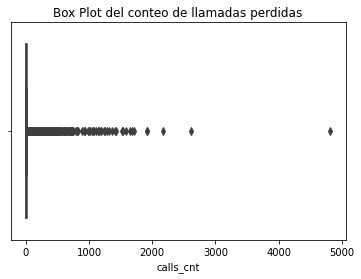

In [ ]:
#Diagrama de caja para el conteo de las llamadas perdidas
sns.boxplot(x=perdidas['calls_cnt'])
plt.title('Box Plot del conteo de llamadas perdidas')
plt.show()

In [ ]:
#Veamos a detalle
perdidas['calls_cnt'].describe().round(2)

count    21453.00
mean        17.52
std         77.99
min          1.00
25%          1.00
50%          3.00
75%         11.00
max       4817.00
Name: calls_cnt, dtype: float64

In [ ]:
#Obtener el rango intercuartílico
# IQR = Q3-Q1
# IQR = 11 - 1
# IQR = 10

#límite del bigote superior = Q3 + 1.5*IQR
#límite del bigote superior = 11 + 15
#límite del bigote superior = 26

#límite del bigote inferior = Q1 - 1.5*IQR
#límite del bigote inferior = 1 - 15
#límite del bigote inferior = -14

atipicos = df[(df['calls_cnt'] < -14) | (df['calls_cnt'] > 26)]
atipicos.shape

(6501, 12)

In [ ]:
# el df perdidas conserva los índices del original, así que
#Dejemos el df original sin los atípicos de esa columna
df = df[~df.index.isin(atipicos.index)]
df.shape

(42334, 12)

#### Llamadas recibidas

In [ ]:
#generar un sub-df
recibidas = df[df['call'] == 'recibida']
len(recibidas)

23700

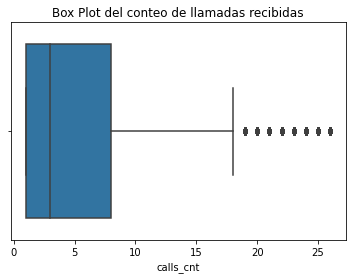

In [ ]:
#Diagrama de caja para el conteo de las llamadas recibidas
sns.boxplot(x=recibidas['calls_cnt'])
plt.title('Box Plot del conteo de llamadas recibidas')
plt.show()

In [ ]:
#Veamos a detalle
recibidas['calls_cnt'].describe().round(2)

count    23700.00
mean         5.86
std          6.10
min          1.00
25%          1.00
50%          3.00
75%          8.00
max         26.00
Name: calls_cnt, dtype: float64

In [ ]:
#Obtener el rango intercuartílico
# IQR = Q3-Q1
# IQR = 8 - 1
# IQR = 7

#límite del bigote superior = Q3 + 1.5*IQR
#límite del bigote superior = 8 + 10.5
#límite del bigote superior = 18.5

#límite del bigote inferior = Q1 - 1.5*IQR
#límite del bigote inferior = 1 - 10.5
#límite del bigote inferior = -9

atipicos = df[(df['calls_cnt'] < -9) | (df['calls_cnt'] > 18.5)]
atipicos.shape

(2473, 12)

In [ ]:
# el df perdidas conserva los índices del original, así que
#Dejemos el df original sin los atípicos de esa columna
df = df[~df.index.isin(atipicos.index)]
df.shape

(39861, 12)

## 3.3.-Llamadas

In [ ]:
#Veamos la cantidad total de llamadas por mes
call_mes = df.groupby(df['date'].dt.to_period("M"))['calls_cnt'].sum()
call_mes = call_mes.to_frame().reset_index()
call_mes

,date,calls_cnt
0,2019-08,6840
1,2019-09,29392
2,2019-10,60733
3,2019-11,79316


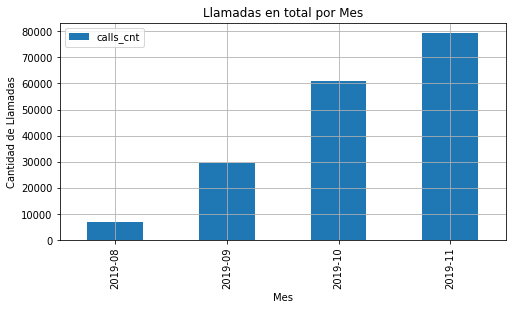

In [ ]:
# gráfico de barras
ax = call_mes.plot(kind='bar', x='date', figsize=(8, 4))
plt.title('Llamadas en total por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Llamadas')
plt.grid()
plt.show()

In [ ]:
# Veamos la cantidad de llamadas perdidas por mes
call_perdida_mes = df[df['call'] == 'perdida'].groupby(df['date'].dt.to_period("M"))['calls_cnt'].sum()
call_perdida_mes = call_perdida_mes.to_frame().reset_index()
call_perdida_mes

,date,calls_cnt
0,2019-08,3443
1,2019-09,12697
2,2019-10,24982
3,2019-11,31240


In [ ]:
# Veamos la cantidad de llamadas recibidas por mes
call_recibida_mes = df[df['call'] == 'recibida'].groupby(df['date'].dt.to_period("M"))['calls_cnt'].sum()
call_recibida_mes = call_recibida_mes.to_frame().reset_index()
call_recibida_mes

,date,calls_cnt
0,2019-08,3397
1,2019-09,16695
2,2019-10,35751
3,2019-11,48076


In [ ]:
#Veamos las perdidas y las recibidas en conjunto
recibidasyperdidas = call_perdida_mes.merge(call_recibida_mes, on='date')
recibidasyperdidas = recibidasyperdidas.rename(columns={
    'calls_cnt_x':'perdidas', 'calls_cnt_y':'recibidas'})
recibidasyperdidas

,date,perdidas,recibidas
0,2019-08,3443,3397
1,2019-09,12697,16695
2,2019-10,24982,35751
3,2019-11,31240,48076


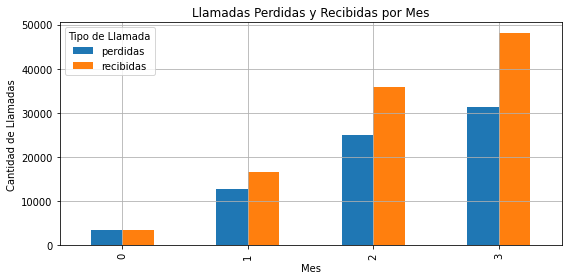

In [ ]:
# gráfico de barras
ax = recibidasyperdidas.plot(kind='bar', figsize=(8, 4))
plt.title('Llamadas Perdidas y Recibidas por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Llamadas')
plt.legend(title='Tipo de Llamada', loc='upper left')
plt.tight_layout()
plt.grid()
plt.show()


Se percibe un aumento tanto en las llamadas perdidas como en las recibidas mes a mes, esto está justificado ya que el aumento de llamadas es general. Lo que es remarcable es que, en el primer mes, las perdidas y recibidas tenían muy poca diferencia entre sí y ésta fue incrementendo con el paso de los meses.

 ## 3.4.-Tiempo de espera

In [ ]:
#Vayamos conociendo los tiempos de espera por mes
w_time_mes = df.groupby(df['date'].dt.to_period("M"))['w_time'].sum()
w_time_mes = w_time_mes.to_frame().reset_index()
w_time_mes

,date,w_time
0,2019-08,107134
1,2019-09,481523
2,2019-10,1040603
3,2019-11,1358667


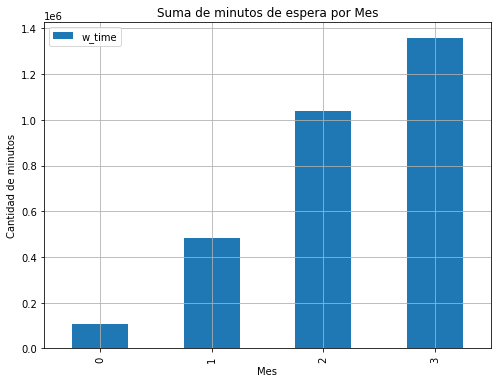

In [ ]:
# gráfico de barras
ax = w_time_mes.plot(kind='bar', figsize=(8, 6))
plt.title('Suma de minutos de espera por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de minutos')
plt.grid()
plt.show()

In [ ]:
w_time_mes['w_per_call'] = w_time_mes['w_time'] / call_mes['calls_cnt']
w_time_mes['w_per_call'] = w_time_mes['w_per_call'].round(2)
w_time_mes

,date,w_time,w_per_call
0,2019-08,107134,15.66
1,2019-09,481523,16.38
2,2019-10,1040603,17.13
3,2019-11,1358667,17.13


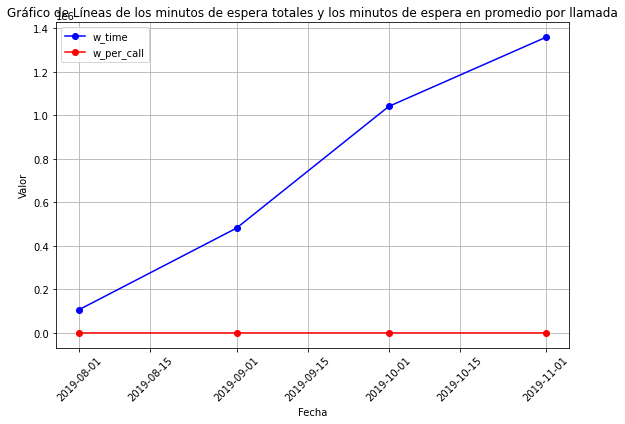

In [ ]:
#Ajustamos la columa date a datetime
w_time_mes['date'] = w_time_mes['date'].dt.to_timestamp()

fecha = w_time_mes['date']
w_time = w_time_mes['w_time']
w_per_call = w_time_mes['w_per_call']

# Grafíco de líneas
plt.figure(figsize=(8, 6))
plt.plot(fecha, w_time, marker='o', linestyle='-', color='b', label='w_time')
plt.plot(fecha, w_per_call, marker='o', linestyle='-', color='r', label='w_per_call')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Gráfico de Líneas de los minutos de espera totales y los minutos de espera en promedio por llamada')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()  # Opcional: ajusta el espaciado para evitar que las etiquetas se recorten
plt.show()


## 3.5-Planes

In [ ]:
#Identificar cuantos planes distintos maneja cada operador
op_plans = df.groupby('operator_id')['tariff_plan'].nunique()
op_plans = op_plans.to_frame()
op_plans.nunique()

tariff_plan    1
dtype: int64

Desde la exploración inicial de datos sabíamos que existen 3 planes: A, B y C. En esta operación se agrupó por operador para saber cuántos tipos de plan maneja cada uno. Tenemos que cada operador responde sólo a un tipo de plan. Podemos descartar con esto que el comportamiento del operador de perder o recibir llamadas, no está relacionado con el tipo de plan del usuario puesto que cada operador solo trabaja con un solo tipo de plan.

In [ ]:
#Cuántos usuarios tenemos en cada plan
us_plans = df.groupby('tariff_plan')['user_id'].nunique()
us_plans = us_plans.to_frame().reset_index()
us_plans

,tariff_plan,user_id
0,A,34
1,B,112
2,C,161


## 3.6 Usuarios

In [ ]:
#Veamos cuántos usuarios sufren de llamadas perdidas según el tipo de ellas
users_affected = perdidas.groupby(['direction','int/ext','tariff_plan'])['user_id'].nunique().sort_values(ascending=False)
users_affected = users_affected.to_frame().reset_index()
users_affected

,direction,int/ext,tariff_plan,user_id
0,in,externa,C,159
1,in,externa,B,111
2,out,externa,C,101
3,out,externa,B,86
4,out,interna,C,68
5,out,interna,B,53
6,in,interna,C,40
7,in,externa,A,33
8,out,externa,A,27
9,in,interna,B,26


In [ ]:
#Agregemos la cantidad de usuarios por plan
users_affected = users_affected.merge(us_plans, on='tariff_plan')
#Y veamos la afectación tomando en cuenta el total de usuarios por plan
users_affected = users_affected.rename(columns={'user_id_x':'users_affected', 'user_id_y':'users_total'})
users_affected['rate'] = (users_affected['users_affected']*100 / users_affected['users_total']).round(2)
users_affected.sort_values(by='rate', ascending=False)

,direction,int/ext,tariff_plan,users_affected,users_total,rate
4,in,externa,B,111,112,99.11
0,in,externa,C,159,161,98.76
8,in,externa,A,33,34,97.06
9,out,externa,A,27,34,79.41
5,out,externa,B,86,112,76.79
1,out,externa,C,101,161,62.73
10,out,interna,A,19,34,55.88
6,out,interna,B,53,112,47.32
2,out,interna,C,68,161,42.24
11,in,interna,A,10,34,29.41


Esta evaluación nos arroja que el tipo de llamada que genera una mayor afectación son:

* En primer lugar, la `externa entrante` en los tres planes, viéndose afectada casi la totalidad de los usuarios por plan. En segundo lugar la `externa saliente` con rangos de afectación a entre el 62.73 y el 79.41% de sus usuarios.

Tenemos problemas con las llamdas internas, pero se afecta a los usuarios en un rango del 55% para abajo.


usuarios más afectados por las llamadas perdidas son los pertenecientes al grupo

## 3.7.-Operadores

In [ ]:
#Veamos con cuántos operadores contamos
df['operator_id'].nunique()

1073

In [ ]:
#Veamos cuantos operadores (de los 1092 totales) tiene únicamente llamadas perdidas en toda su actividad registrada
c = df.groupby('operator_id')['call'].value_counts().reset_index(name='cnt')
d = c[(c['call'] == 'recibida') & (c['cnt'] == 0)]
d


,operator_id,call,cnt


Con esta información, se puede descartar que no tengamos operadores ausentes, sí registrados, pero si operar, es decir, todos los operadores tienen al menos una llamada recibida, aunque obviamente este nivel tan bajo será digno de análisis más adelante.

## 3.8.-Correlaciones

Matriz de correlación

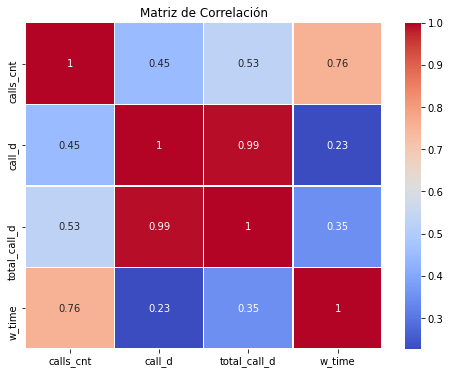

In [ ]:
# Seleccionar el subconjunto de columnas a incluir
cols = ['calls_cnt', 'call_d', 'total_call_d', 'w_time']
df_cols = df[cols]

#Hagamos una matríz de correlación
correlaciones = df_cols.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()

La matriz demuestra que hay una correlación positiva, es decir a mayor duración de llamada, mayor duración de llamada total que incluye los tiempos de espera.

También muestra que hay una correlación más fuerte entre el número de llamadas y el tiempo de espera, que con el número de llamadas y la duración de las llamadas. Esto porque al haber mayor número de llamadas y el mismo número de operadores, obligatoriamente aumentarán los tiempos de espera.


In [ ]:
recibidasyperdidas.corr()

,perdidas,recibidas
perdidas,1.00000,0.99838
recibidas,0.99838,1.00000


Este análisis es importante: hay una alta correlación positiva entre las llamadas perdidas y las recibidas. Es decir, no aplica en este caso el suspuesto de que el aumento de llamadas perdidas significa un aumento en llamada no recibidas.

## 3.9.-Identificar operadores ineficaces

### Con **más** llamadas perdidas

In [ ]:
perdidas.head(3)

,user_id,date,direction,int/ext,operator_id,call,calls_cnt,call_d,total_call_d,tariff_plan,date_start,w_time
0,166377,2019-08-04,in,externa,NaN,perdida,2,0,4,B,2019-08-01,4
1,166377,2019-08-05,out,interna,880022.0,perdida,3,0,5,B,2019-08-01,5
2,166377,2019-08-05,out,interna,880020.0,perdida,1,0,1,B,2019-08-01,1


In [ ]:
#Obtener los operadores que tengan un mayor número de llamadas perdidas
perdidas_op = perdidas.groupby('operator_id')['calls_cnt'].sum().sort_values(ascending=False)
perdidas_op

operator_id
885890.0    23807
885876.0    23330
929428.0    19118
925922.0     9258
908640.0     8164
            ...  
932856.0        1
934000.0        1
934074.0        1
934076.0        1
922114.0        1
Name: calls_cnt, Length: 876, dtype: int64

In [ ]:
#Identifiquemos el percentil 75
perdidas_op.describe().round(2)

count      876.00
mean       310.87
std       1418.35
min          1.00
25%          6.00
50%         34.00
75%        229.00
max      23807.00
Name: calls_cnt, dtype: float64

In [ ]:
#quedarnos solo con  los operadores con el 25% más alto en la cantidad de llamadas
perdidas_op_top = perdidas_op[perdidas_op >= 229]
perdidas_op_top = perdidas_op_top.to_frame().reset_index()
perdidas_op_top

,operator_id,calls_cnt
0,885890.0,23807
1,885876.0,23330
2,929428.0,19118
3,925922.0,9258
4,908640.0,8164
...,...,...
215,917852.0,236
216,905566.0,235
217,945298.0,229
218,947640.0,229


### Con **menos** llamadas recibidas

In [ ]:
#Obtener los operadores que tengan un mayor número de llamadas recibidas
recibidas_op = recibidas.groupby('operator_id')['calls_cnt'].sum().sort_values(ascending=False)
recibidas_op

operator_id
901880.0    2350
899082.0    1632
901884.0    1624
913788.0    1429
906406.0    1417
            ... 
917890.0       1
918988.0       1
919206.0       1
919490.0       1
948282.0       1
Name: calls_cnt, Length: 1028, dtype: int64

In [ ]:
#Identifiquemos el percentil 25 para quedarnos solo con
#los operadores con el 25% más bajo en la cantidad de llamadas
recibidas_op.describe().round(2)

count    1028.00
mean      135.03
std       246.89
min         1.00
25%         7.00
50%        33.00
75%       156.25
max      2350.00
Name: calls_cnt, dtype: float64

In [ ]:
#quedarnos solo con  los operadores con el 25% más bajo en la cantidad de llamadas
recibidas_op_bottom = recibidas_op[recibidas_op <= 7]
recibidas_op_bottom = recibidas_op_bottom.to_frame().reset_index()
recibidas_op_bottom

,operator_id,calls_cnt
0,892798.0,7
1,934188.0,7
2,928142.0,7
3,940788.0,7
4,970254.0,7
...,...,...
258,917890.0,1
259,918988.0,1
260,919206.0,1
261,919490.0,1


### Con **más** tiempo de espera

In [ ]:
#Obtener los operadores que tengan un mayor número de llamadas recibidas
w_op = df.groupby('operator_id')['w_time'].sum().sort_values(ascending=False)
w_op

operator_id
899082.0    30427
901884.0    27400
887276.0    25309
890404.0    24694
890402.0    24025
            ...  
919382.0        0
938078.0        0
952466.0        0
960674.0        0
945322.0        0
Name: w_time, Length: 1073, dtype: int64

In [ ]:
#Identifiquemos el percentil 75 para quedarnos solo con
#los operadores con el 25% más alto en la cantidad de minutos de espera
w_op.describe().round(2)

count     1073.00
mean      2372.60
std       4252.27
min          0.00
25%        105.00
50%        575.00
75%       2414.00
max      30427.00
Name: w_time, dtype: float64

In [ ]:
#quedarnos solo con  los operadores con el 25% más alto en la cantidad de llamadas
w_op_top = w_op[w_op >= 2414]
w_op_top = w_op_top.to_frame().reset_index()
w_op_top

,operator_id,w_time
0,899082.0,30427
1,901884.0,27400
2,887276.0,25309
3,890404.0,24694
4,890402.0,24025
...,...,...
264,939886.0,2469
265,884478.0,2469
266,936110.0,2434
267,924954.0,2425


### Tamizado: **operadores ineficaces**

Recordemos que tenemos un total de 1073 operadores.

In [ ]:
#Unir los operadores ineficientes
#muchas llamadas perdidas, más, muchos minutos de espera.
#importante: usar inner para las coincidencias
inef = w_op_top.merge(perdidas_op_top, how='inner', on='operator_id')
inef

,operator_id,w_time,calls_cnt
0,899082.0,30427,480
1,901884.0,27400,617
2,887276.0,25309,268
3,890404.0,24694,495
4,890402.0,24025,447
...,...,...,...
104,945282.0,2901,719
105,945296.0,2871,1042
106,904016.0,2729,2359
107,939706.0,2640,290


La tabla anterior reúne a los 109 operadores más ineficaces a partir de sus altos valores en minutos de espera y llamadas perdidas.

In [ ]:
#Quiénes son estos 109 operadores
inef['operator_id'].unique()

array([899082., 901884., 887276., 890404., 890402., 901880., 880028.,
       890406., 913788., 915556., 903254., 923526., 899250., 889410.,
       906406., 905538., 925104., 890416., 901886., 903318., 937708.,
       890410., 891410., 905844., 889754., 900892., 921818., 937902.,
       922142., 893804., 890412., 882686., 917852., 905542., 880026.,
       937888., 902510., 937760., 937854., 885876., 937808., 937780.,
       938896., 883942., 939222., 918978., 905842., 918986., 928886.,
       905566., 941384., 937736., 891414., 937788., 902532., 937966.,
       939376., 907174., 939762., 894656., 890420., 926486., 941192.,
       891416., 879898., 884412., 902742., 887282., 882690., 900180.,
       937752., 931458., 945298., 893674., 914052., 954650., 884946.,
       947652., 879896., 902720., 921318., 902782., 902774., 892028.,
       945314., 917234., 937860., 945312., 928312., 939738., 885890.,
       899932., 904014., 929424., 905430., 940624., 899788., 952948.,
       947604., 9019

In [ ]:
#Hacer coincidir estos operadores ineficientes con los operadores de pocas llamadas recibidas
inef2 = inef.merge(recibidas_op_bottom, how='inner', on='operator_id')
inef2

,operator_id,w_time,calls_cnt_x,calls_cnt_y


No hay coincidencias entre los operadores que reúnen muchas llamadas perdidas y muchos minutos de espera, con los operadores que reciben pocas llamadas por lo que este último parámetro no se considerará como parte del comportamiento del operador ineficiente.

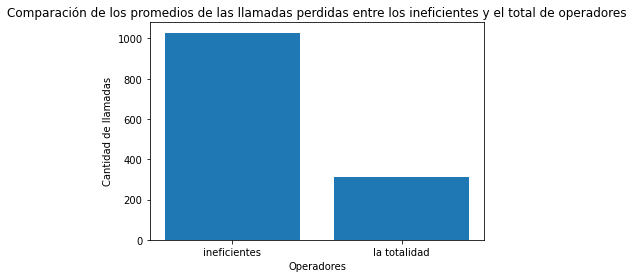

In [ ]:
#Veamos las llamadas perdidas en comparación

# promedio de las sumas de llamadas para cada usuario ineficiente
perdidas_inef = inef['calls_cnt'].mean().round(2)
# promedio de las sumas de llamadas para cada usuario del df
perdidas_df = perdidas.groupby('operator_id')['calls_cnt'].sum()
perdidas_df = perdidas_df.mean().round(2)

# Crear un gráfico de barras
etiquetas = ['ineficientes', 'la totalidad']
valores = [perdidas_inef, perdidas_df]

plt.bar(etiquetas, valores)
plt.xlabel('Operadores')
plt.ylabel('Cantidad de llamadas')
plt.title('Comparación de los promedios de las llamadas perdidas entre los ineficientes y el total de operadores')
plt.show()

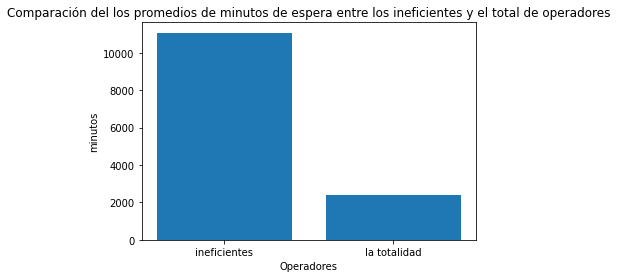

In [ ]:
#Veamos los minutos de espera en comparación

# promedio de las sumas de w_time para cada usuario ineficiente
w_time_inef = inef['w_time'].mean().round(2)
# promedio de las sumas de w_time para cada usuario del df
w_time_df = df.groupby('operator_id')['w_time'].sum()
w_time_df = w_time_df.mean().round(2)

# Crear un gráfico de barras
etiquetas = ['ineficientes', 'la totalidad']
valores = [w_time_inef, w_time_df]

plt.bar(etiquetas, valores)
plt.xlabel('Operadores')
plt.ylabel('minutos')
plt.title('Comparación del los promedios de minutos de espera entre los ineficientes y el total de operadores')
plt.show()

Identificar a qué plan tarifario atienden estos operadores

In [ ]:
#Generemos un df con las observaciones de únicamente los operadores ineficientes
df_inef = df[df['operator_id'].isin(inef['operator_id'])]
df_inef
#Ya sabemos que cada operador responde a un solo plan,
#así que veamos cuantos operadores, de los 109 ineficientes corresponden a cada plan
inef_plans = df_inef.groupby('tariff_plan')['operator_id'].nunique()
inef_plans = inef_plans.to_frame().reset_index()
inef_plans

,tariff_plan,operator_id
0,A,27
1,B,37
2,C,45


In [ ]:
#Generamos un df sin las observaciones de los operadores ineficientes
df_ef = df[~df['operator_id'].isin(inef['operator_id'])]
df_ef = df_ef
df_ef

,user_id,date,direction,int/ext,operator_id,call,calls_cnt,call_d,total_call_d,tariff_plan,date_start,w_time
0,166377,2019-08-04,in,externa,NaN,perdida,2,0,4,B,2019-08-01,4
1,166377,2019-08-05,out,interna,880022.0,perdida,3,0,5,B,2019-08-01,5
2,166377,2019-08-05,out,interna,880020.0,perdida,1,0,1,B,2019-08-01,1
3,166377,2019-08-05,out,interna,880020.0,recibida,1,10,18,B,2019-08-01,8
4,166377,2019-08-05,out,externa,880022.0,perdida,3,0,25,B,2019-08-01,25
...,...,...,...,...,...,...,...,...,...,...,...,...
48830,168606,2019-11-10,out,interna,957922.0,recibida,1,0,25,C,2019-10-31,25
48831,168606,2019-11-10,out,interna,957922.0,perdida,1,0,38,C,2019-10-31,38
48832,168606,2019-11-11,out,interna,957922.0,recibida,2,479,501,C,2019-10-31,22
48833,168606,2019-11-15,out,interna,957922.0,recibida,4,3130,3190,C,2019-10-31,60


In [ ]:
#Cuántos usuarios hay por plan
clients.groupby('tariff_plan')['user_id'].count()

tariff_plan
A     76
B    261
C    395
Name: user_id, dtype: int64

In [ ]:
#Generemos un df con las observaciones de únicamente los operadores ineficientes
df_inef = df[df['operator_id'].isin(inef['operator_id'])]
df_inef = df_inef
df_inef

,user_id,date,direction,int/ext,operator_id,call,calls_cnt,call_d,total_call_d,tariff_plan,date_start,w_time
13,166377,2019-08-07,out,externa,880028.0,perdida,1,0,15,B,2019-08-01,15
14,166377,2019-08-07,out,externa,880026.0,recibida,1,21,28,B,2019-08-01,7
17,166377,2019-08-07,out,externa,880026.0,perdida,1,0,17,B,2019-08-01,17
20,166377,2019-08-09,out,externa,880028.0,recibida,17,1603,1725,B,2019-08-01,122
21,166377,2019-08-09,out,externa,880028.0,perdida,2,0,2,B,2019-08-01,2
...,...,...,...,...,...,...,...,...,...,...,...,...
48808,168601,2019-11-26,out,externa,952914.0,perdida,7,0,208,C,2019-10-31,208
48809,168601,2019-11-26,in,externa,952914.0,recibida,4,539,562,C,2019-10-31,23
48812,168601,2019-11-27,in,externa,952914.0,recibida,2,53,77,C,2019-10-31,24
48814,168601,2019-11-27,out,externa,952914.0,perdida,2,0,14,C,2019-10-31,14


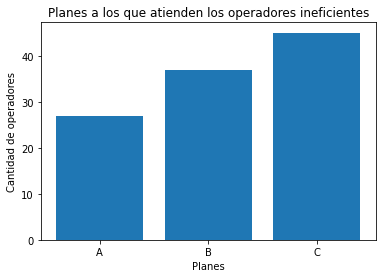

In [ ]:
plt.bar(inef_plans['tariff_plan'], inef_plans['operator_id'])
plt.xlabel('Planes')
plt.ylabel('Cantidad de operadores')
plt.title('Planes a los que atienden los operadores ineficientes')
plt.show()

# 4.-Prueba <a id='4'></a>

#### Probar la hipótesis de que las proporciones son iguales

Hacer la prueba de `hipótesis sobre la igualdad de las medias de dos poblaciones` para comparar las medias de usuarios que atienden operadores eficientes y los ineficientes.

In [ ]:
#preparemos las medias
df_ef_users = df_ef.groupby('operator_id')['user_id'].count().mean()
print(f'{df_ef_users.round(2)} es la media usuarios que tiene cada operador del grupo eficiente')
df_inef_users = df_inef.groupby('operator_id')['user_id'].count().mean()
print(f'{df_inef_users.round(2)} es la media de usuarios que tiene cada operador del grupo ineficiente')


23.97 es la media usuarios que tiene cada operador del grupo eficiente
93.62 es la media de usuarios que tiene cada operador del grupo ineficiente


In [ ]:
#Realicemos la prueba
alpha = .05 # nivel de significación

    #Estos éxitos son las medias de usuarios del grupo eficiente y el ineficiente
successes = np.array([23.97, 93.62])
    #Estos trials son las cantidades de operadores del grupo eficiente y el ineficiente
trials = np.array([964, 109])

# proporción de éxito en el grupo A:
p1 = successes[0]/trials[0]

# proporción de éxito en el grupo B:
p2 = successes[1]/trials[1]

# proporción de éxito en el dataset unido:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# la diferencia entre las proporciones de los datasets
difference = p1 - p2

In [ ]:
# calcular la estadística en desviaciones estándar de la distribución normal estándar
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# establece la distribución normal estándar (media 0, desviación estándar 1)
distr = st.norm(0, 1)

In [ ]:
# calcular la estadística en desviaciones estándar de la distribución normal estándar
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# establece la distribución normal estándar (media 0, desviación estándar 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', p_value)

if (p_value < alpha):
    print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes")

p-value:  0.0
Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones


# 5.-Conclusiones

Propósito:

Con los datos proporcionados, se buscó identificar a los operadores ineficaces del servicio de telefonía virtual CallMeMaybe tanto en su atención a llamadas internas y externas, salientes y entrantes.

Se preprocesaron los datos, se buscaron duplicados, nulos y necesidades como uniones de dataframes, nuevas columnas, conversiones de tipos, y manejo de atípicos.

Se hicieron observaciones de los datos desde distintos ángulos para entender mejor el funcionamiento en su conjunto. Se estudiaron correlaciones y tendencias. Estos son hallazgos más relevantes.

* Se percibe un aumento tanto en las llamadas perdidas como en las recibidas mes a mes, esto está justificado ya que hay un aumento generalizado.

* En el primer mes, las perdidas y recibidas tenían muy poca diferencia entre sí y ésta se fue incrementando con el paso de los meses.

* En los minutos de espera divididos entre la cantidad de llamadas, sí hay diferencia mes a mes, pero no es significativa.

* Las llamadas perdidas `externa entrante` son las que afectan más los 3 planes, en este orden, B, C y A, viéndose afectada casi la totalidad de los usuarios por plan, 99%, 98% y 97%.

* Las llamadas perdidas `externa saliente` tienen rangos de afectación a entre el 62.73 y el 79.41% de sus usuarios. No tan altos como el tipo anterior.

* Hay una correlación más fuerte entre el número de llamadas y el tiempo de espera, que con el número de llamadas y la duración de las llamadas.

* Hay una alta correlación positiva entre las llamadas perdidas y las recibidas. Es decir, no aplica, en este caso, el supuesto de que el aumento de llamadas perdidas significa un aumento en llamada no recibidas.

Con la considreación de que un operador es ineficaz si tiene:

* una gran cantidad de llamadas entrantes perdidas (internas y externas), esto definido por el 25% más alto de `missing_calls`.

* un tiempo de espera prolongado para las llamadas entrantes, definido de igual forma por el 25% más alto de un `waiting_time`.

Se generó un listado de los 109 operadores en este rango.

El [PDF de la presentación de conclusiones](https://drive.google.com/file/d/17TmYrB4I9wgi5KoNGe1OAMuuaGeAjhrv/view?usp=sharing) y el [Dashboard](https://public.tableau.com/views/CallMeMaybe_16957484570890/CallMeMaybe?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link) ayudan a la comprensión de esta información.



# 6.-Documentación

* Jupyter Team.(2015). Markdown Cells. *Jupyter*. https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html

* Jupyter Team. (2015). Markdown for Jupyter notebooks cheatsheet. *Jupyter*. https://www.ibm.com/docs/en/watson-studio-local/1.2.3?topic=notebooks-markdown-jupyter-cheatsheet

Usé esta información en la fase de descomposición de mi proyecto ya que tenía algunos errores tan elementales como la falta como el espacio entre el hashtag y los títulos, pero tuve que descubrirlo investigando.

* McKinney, W. (2022). Detecting and Filtering Outliers. *Python for Data Analysis* (3rd ed). O'Reilly. pp.217-219.

* Dhadse, a. (2021, April 5). Removing Outliers. Understanding How and What behind the Magic. *Medium.* https://medium.com/analytics-vidhya/removing-outliers-understanding-how-and-what-behind-the-magic-18a78ab480ff

Al inicio del proyecto probé con remover los atípicos de todas las columnas que podían tenerlos, evalúe que esto perjudicaba mucho mi dataframe. Decidí retirar los atípicos de la columna que consideré de mayor importancia. En esta fuente y estaba buscando información sobre la toma de decisiones más que sobre el proceso técnico, pero sirvió revisarlo. Estas lecturas también me ayudaron a constatar que el cambio de comportamiento mes a mes de solo aumentar a aumentar y luego bajar, sí se debía en efecto a los atípicos, lo que me confirmó que debía quitarlos.

* VanderPlas, J. (2016). Pivot Tables. *Python Data Science Handbook*. O'Reilly. https://jakevdp.github.io/PythonDataScienceHandbook/03.09-pivot-tables.html

En algunas ocasiones confundo los alcances de un pivot table o un groupby, resultó que para el proyecto mis necesidades fueron satisfechas con groupby, pero me sirvió revisar esta información para estar segura.

* OpenAI. (2023). ChatGPT (Aug 3 version) [Large language model]. https://chat.openai.com/chat

Texto en respuesta al prompt "diferencia entre cuartiles y cuantiles" porque al trabajar los rangos intercuartilícos resurgieron términos que no dominaba por completo, percentil, cuantil, cuartil, etc.

* Google Colaborary. (n. d.). Frequently Asked Questions. *Google Colab*. https://research.google.com/colaboratory/faq.html

* CCTMéxico. (2021 julio 8). ¿Cómo cargar y descargar archivos CSV desde Google Colab? *Youtube*.  https://www.youtube.com/watch?v=ft9bSa49k-A

Para crear el dashboard en Tableau, necesita dos dataframes nuevos que generé en el notebook, no los dataframes originales de consulta. Necesitaba exportarlos y estas dos fuentes me ayudaron a ello.




---



---

